In [1]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras_tuner as kt
import random
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

In [2]:
# Set the random seed for reproducibility
seed_value = 22
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [3]:
df=pd.read_csv("dataset.csv")

In [4]:
df.columns

Index(['Unnamed: 0', 'activity', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'call',
       'circumplex.arousal', 'circumplex.valence', 'mood', 'screen', 'sms',
       'id', 'day', 'target_mood'],
      dtype='object')

In [5]:
#sort by data 
df['day'] = pd.to_datetime(df['day'])
df = df.sort_values(by='day')

In [6]:
df['day']

541   2014-03-13
268   2014-03-13
396   2014-03-13
127   2014-03-14
489   2014-03-14
         ...    
809   2014-06-03
810   2014-06-04
811   2014-06-05
812   2014-06-06
813   2014-06-07
Name: day, Length: 1169, dtype: datetime64[ns]

In [7]:
#verify how many days are there per person
day_counts = df.groupby('id')['day'].nunique()
print(day_counts)

id
AS14.01    44
AS14.02    37
AS14.03    46
AS14.05    52
AS14.06    43
AS14.07    46
AS14.08    53
AS14.09    36
AS14.12    39
AS14.13    51
AS14.14    42
AS14.15    52
AS14.16    52
AS14.17    44
AS14.19    45
AS14.20    40
AS14.23    38
AS14.24    54
AS14.25    29
AS14.26    45
AS14.27    40
AS14.28    37
AS14.29    40
AS14.30    45
AS14.31    42
AS14.32    36
AS14.33    41
Name: day, dtype: int64


In [8]:
len(df['day'].unique())

86

In [9]:
list_names = df['id'].unique()
len(df['id'].unique())

27

Mean:              6.9893
Median :       7.0000
25th percentile : 6.6000
75th percentile : 7.5000
IQR: 0.9000


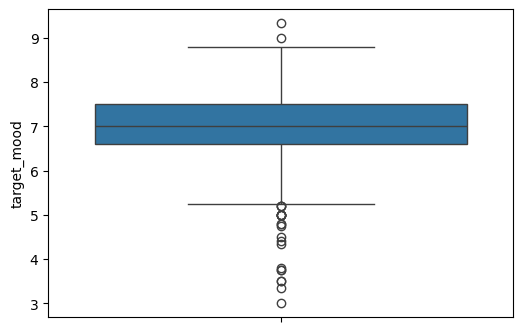

In [10]:

mean_val = df['target_mood'].mean()
median_val = df['target_mood'].median() # 
q1_val = df['target_mood'].quantile(0.25) 
q3_val = df['target_mood'].quantile(0.75)
iqr_val = q3_val - q1_val

print(f"Mean:              {mean_val:.4f}")
print(f"Median :       {median_val:.4f}")
print(f"25th percentile : {q1_val:.4f}")
print(f"75th percentile : {q3_val:.4f}")
print(f"IQR: {iqr_val:.4f}")

plt.figure(figsize=(6, 4))
sns.boxplot(y=df['target_mood']) 
plt.show()

In [11]:
def map_mood_to_class(mood):
    if mood <= 4:
        return 0  # sad
    elif mood <= 7:
        return 1  # neutral
    else:
        return 2  # happy
        
#create new categrocal target value
df["mood_class"] = df["target_mood"].apply(map_mood_to_class)

df['mood_class'].value_counts(dropna=False).sort_index()

mood_class
0      7
1    649
2    513
Name: count, dtype: int64

In [12]:
list_names = df['id'].unique()
train_names = list_names[:21]
val_names = list_names[21:24]
test_names = list_names[24:27]


In [13]:
window_size = 4 # parameter - Defines the size of the sliding window (number of consecutive days) for creating sequences.
X_all = [] # Initialize an empty list to store all feature sequences.
y_all = [] # Initialize an empty list to store all target mood classes.
subject_seq_ids = [] # Initialize an empty list to store the subject ID for each sequence.

for subj in df['id'].unique(): # Iterate through each unique subject ID in the 'id' column of the DataFrame.
    df_subj = df[df['id'] == subj].sort_values('day') # Filter the DataFrame to get data for the current subject and sort it by day.
    features = df_subj.drop(columns=['id', 'day', 'target_mood', 'Unnamed: 0', 'mood_class']).to_numpy() # Extract feature columns (excluding identifiers, target, and mood_class) and convert to a NumPy array.
    targets = df_subj['mood_class'].to_numpy() # Extract the 'mood_class' column (target variable) and convert to a NumPy array.

    for i in range(len(df_subj) - window_size): # Iterate through the data points of the current subject to create sequences.
        X_all.append(features[i:i+window_size]) # Append a sequence of 'window_size' consecutive feature vectors to X_all.
        y_all.append(targets[i+window_size]) # Append the target mood class (the day after the window) to y_all.
        subject_seq_ids.append(subj)  # track who this sample belongs to - Append the subject ID for the current sequence.

X_all = np.array(X_all) # Convert the list of feature sequences to a NumPy array.
y_all_cat = to_categorical(y_all, num_classes=3) # Convert the list of target labels to one-hot encoded categorical format (3 classes).
subject_seq_ids = np.array(subject_seq_ids) # Convert the list of subject IDs to a NumPy array.


In [14]:
# Convert train/val/test subject names to sets for faster lookup
train_ids = set(train_names)
val_ids = set(val_names)
test_ids = set(test_names)

# Create boolean masks
train_mask = np.isin(subject_seq_ids, list(train_ids))
val_mask = np.isin(subject_seq_ids, list(val_ids))
test_mask = np.isin(subject_seq_ids, list(test_ids))

# Split the data
X_train = X_all[train_mask]
y_train_cat = y_all_cat[train_mask]

X_val = X_all[val_mask]
y_val_cat = y_all_cat[val_mask]

X_test = X_all[test_mask]
y_test_cat = y_all_cat[test_mask]

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)

num_features = X_train.shape[2] 

Train shape: (834, 4, 19)
Val shape: (99, 4, 19)
Test shape: (128, 4, 19)


In [15]:
y_train_labels = np.argmax(y_train_cat, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

In [16]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units_lstm1', min_value=32, max_value=256, step=32),
                   return_sequences=True,
                   input_shape=(window_size, num_features)))
    model.add(Dropout(hp.Float('dropout_rate1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units_lstm2', min_value=16, max_value=128, step=16)))
    model.add(Dense(units=hp.Int('units_dense', min_value=8, max_value=64, step=8),
                    activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate2', min_value=0.05, max_value=0.4, step=0.05)))
    model.add(Dense(3, activation='softmax'))
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd', 'nadam'])
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [17]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,
    directory="my_dir",
    project_name="nn_tuning" 
    #,overwrite=True
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
################################################################################### HYPERPARAMTER TUNING ONLY FOR THE DEFAULT TRAININSDATA
tuner.search(
    X_train, y_train_cat,
    epochs=100,
    validation_data=(X_val, y_val_cat),
    callbacks=[stop_early],
    verbose=1 
    #,class_weight= class_weight_dict

)

Reloading Tuner from my_dir\nn_tuning\tuner0.json


In [18]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters Dictionary:", best_hps.values)


Best Hyperparameters Dictionary: {'units_lstm1': 32, 'dropout_rate1': 0.30000000000000004, 'units_lstm2': 32, 'units_dense': 8, 'dropout_rate2': 0.2, 'optimizer': 'adam'}


In [19]:
# Train the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train_cat, epochs=40, batch_size=32, validation_data=(X_val, y_val_cat))

Epoch 1/40


C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4927 - loss: 1.0864 - val_accuracy: 0.5960 - val_loss: 0.9914
Epoch 2/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5427 - loss: 0.9895 - val_accuracy: 0.5960 - val_loss: 0.8836
Epoch 3/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5415 - loss: 0.9112 - val_accuracy: 0.5960 - val_loss: 0.7925
Epoch 4/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5604 - loss: 0.8564 - val_accuracy: 0.5960 - val_loss: 0.7399
Epoch 5/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5427 - loss: 0.8259 - val_accuracy: 0.5960 - val_loss: 0.7156
Epoch 6/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5372 - loss: 0.8128 - val_accuracy: 0.5960 - val_loss: 0.6982
Epoch 7/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5563 - loss: 0.7981 - val_accuracy: 0.5859 - val_loss: 0.6919
Epoch 8/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5838 - loss: 0.7698 - val_accuracy: 0.5152 - val_loss: 0.6906
Ep

In [20]:
# Extract true labels from the test_dataset:
y_true = np.argmax(y_test_cat, axis=1)

# Get predicted probabilities (y_pred_probs) using X_test:
y_pred_probs = best_model.predict(X_test)

# Convert predicted probabilities to class labels (y_pred):
y_pred = np.argmax(y_pred_probs, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


Test Loss: 0.6859
Test Accuracy: 0.6406
              precision    recall  f1-score   support

     Sad (0)       0.00      0.00      0.00         0
 Neutral (1)       0.71      0.73      0.72        82
   Happy (2)       0.50      0.48      0.49        46

    accuracy                           0.64       128
   macro avg       0.40      0.40      0.40       128
weighted avg       0.64      0.64      0.64       128



<Figure size 600x500 with 0 Axes>

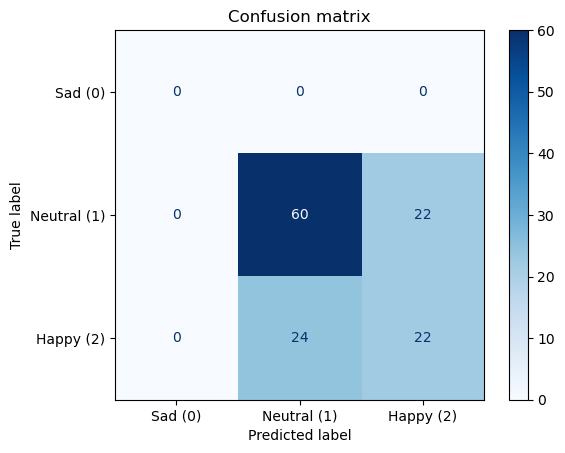

In [21]:
expected_labels = [0, 1, 2]
target_names = ['Sad (0)', 'Neutral (1)', 'Happy (2)']

# Evaluating the code using X_test and y_test_cat
loss, acc = best_model.evaluate(X_test, y_test_cat, verbose=0) # Added verbose=0 to suppress output

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

# Classification report
print(classification_report(y_true, y_pred,
                            labels=expected_labels,
                            target_names=target_names,
                            zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=expected_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion matrix")
plt.show()